In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
pd.set_option('display.max_columns', None)

/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx


In [2]:
##Read in Dataframe and look at the values associated with each column
df= pd.read_excel('/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx')
for column in df.columns:
    print(f'Column: {column} - Unique Values {df[column].unique()}')

Column: CustomerID - Unique Values ['3668-QPYBK' '9237-HQITU' '9305-CDSKC' ... '2234-XADUH' '4801-JZAZL'
 '3186-AJIEK']
Column: Count - Unique Values [1]
Column: Country - Unique Values ['United States']
Column: State - Unique Values ['California']
Column: City - Unique Values ['Los Angeles' 'Beverly Hills' 'Huntington Park' ... 'Standish' 'Tulelake'
 'Olympic Valley']
Column: Zip Code - Unique Values [90003 90005 90006 ... 96128 96134 96146]
Column: Lat Long - Unique Values ['33.964131, -118.272783' '34.059281, -118.30742' '34.048013, -118.293953'
 ... '40.346634, -120.386422' '41.813521, -121.492666'
 '39.191797, -120.212401']
Column: Latitude - Unique Values [33.964131 34.059281 34.048013 ... 40.346634 41.813521 39.191797]
Column: Longitude - Unique Values [-118.272783 -118.30742  -118.293953 ... -120.386422 -121.492666
 -120.212401]
Column: Gender - Unique Values ['Male' 'Female']
Column: Senior Citizen - Unique Values ['No' 'Yes']
Column: Partner - Unique Values ['No' 'Yes']
Colum

In [3]:
##List of columns with multiple values for later
encoding_cols = ['Payment Method','Contract','Streaming Movies','Streaming TV','Tech Support','Device Protection',
                 'Online Backup','Online Security','Internet Service','Multiple Lines']

In [4]:
##Check for null values and make sure data read in correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [5]:
##Total charges read in incorrectly, fixing the column to numeric value. No null values in dataset
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors = 'coerce')
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [6]:
## Dataset is fairly clean, NAs for churn reason likely from customer not churning. NA's from Total Charges need to be fixed
##Look at the null values rows and  see what needs to be doen to the null values
df = df.drop('CustomerID', axis = 1)
print(df[df['Total Charges'].isnull()])

      Count        Country       State            City  Zip Code  \
2234      1  United States  California  San Bernardino     92408   
2438      1  United States  California    Independence     93526   
2568      1  United States  California       San Mateo     94401   
2667      1  United States  California       Cupertino     95014   
2856      1  United States  California        Redcrest     95569   
4331      1  United States  California     Los Angeles     90029   
4687      1  United States  California        Sun City     92585   
5104      1  United States  California      Ben Lomond     95005   
5719      1  United States  California        La Verne     91750   
6772      1  United States  California            Bell     90201   
6840      1  United States  California      Wilmington     90744   

                    Lat Long   Latitude   Longitude  Gender Senior Citizen  \
2234  34.084909, -117.258107  34.084909 -117.258107  Female             No   
2438  36.869584, -118.18924

In [7]:
## Nulls seem to be a data input error as there are monthly charges but no total charge recorded.
## Since they make up a small part of the dataset it is best to remove them- imputing them would be difficult and inacurate
df.dropna(subset = ['Total Charges'], axis = 0, inplace= True)
##See if there are any instances of a churn occuring and no reason being provided
df[(df['Churn Reason'].isnull() == True) & (df['Churn Value'] == 1)]

,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason


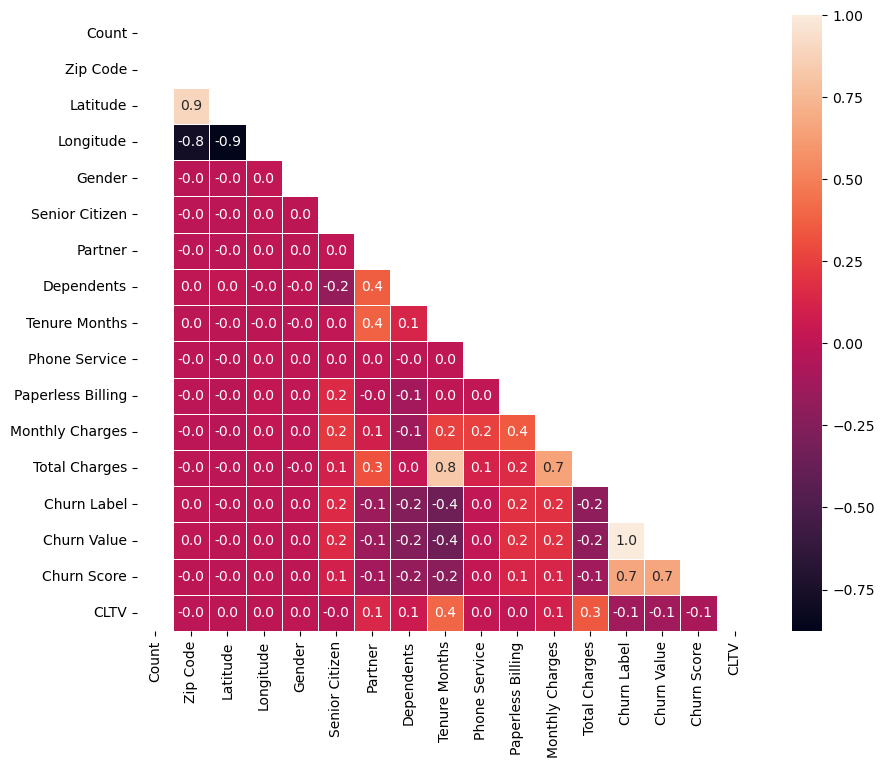

In [8]:
##Exploratory Data Analysis
hm_df = df.copy()
hm_df.Gender = hm_df.Gender.replace({'Male':0, 'Female':1})
yes_no = ['Senior Citizen','Partner','Dependents','Phone Service','Paperless Billing', 'Churn Label']
for i in yes_no:
    hm_df[i] = hm_df[i].replace({'Yes':1,'No':0})
corr = hm_df.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr, dtype = bool))
##Create the heatmap for the numeric df
plt.figure(figsize = (10,8))
sns.heatmap(corr, mask = mask, square = True, fmt = '0.1f', annot = True, linewidths = 0.5)
plt.show()


## From the heatmap we can see that the most impactful of the features that are numeric are the tenure of the customer. 
*  Longer tenure means lower churn
## Other impactful factors are if the customer is a senior citizen, has a partner, has dependents, paperless billing and both total and monthly charges
* Higher charges are more likely to churn (monthly charges more insightful since tenure is shown to decrease churn)
* dependents and partners decrease churn
* Senior citizens churn at a higher rate than younger counterparts
* Paperless billing is also associated with higher churn rates

Text(0.5, 0, 'Tenure (Months)')

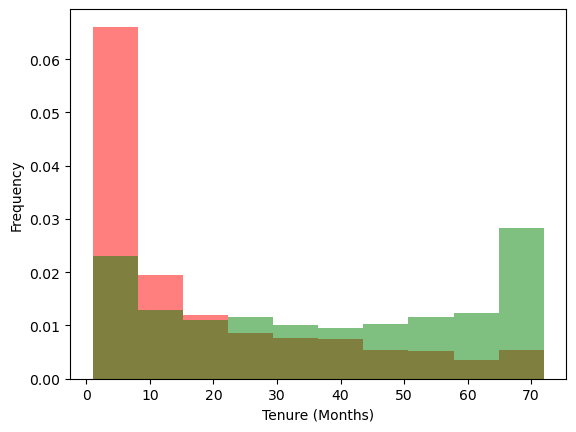

In [9]:
df[df['Churn Label'] == 'Yes']['Tenure Months'].plot(kind='hist',color='red', alpha = 0.5, density = True)
df[df['Churn Label'] == 'No'] ['Tenure Months'].plot(kind='hist', color = 'green',alpha = 0.5, density = True)
plt.xlabel('Tenure (Months)')

Text(0.5, 1.0, 'Value Counts by Churn')

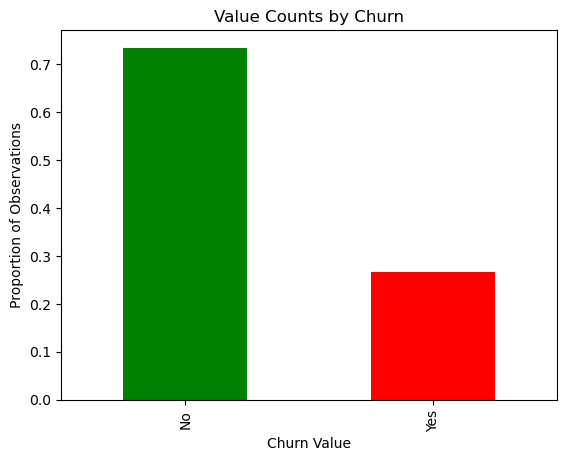

In [10]:
df['Churn Label'].value_counts(normalize = True).plot(kind = 'bar',color = ['green','red'])
plt.xlabel('Churn Value')
plt.ylabel('Proportion of Observations')
plt.title('Value Counts by Churn')

## Many more non-churn observances in the dataset than churn customers.

In [11]:
#Get relationship scores between categorical variables and churn
correls = hm_df.corr(numeric_only = True).sort_values(by = 'Churn Score', ascending = False)
numeric_value = correls[['Churn Value']]

In [12]:
def mutual_scoring(cat_series):
    return metrics.mutual_info_score(cat_series,df['Churn Label'])
cat_df = df.select_dtypes(include = 'object').drop(['Churn Label','Churn Reason'], axis=1)
feature_val = cat_df.apply(mutual_scoring).sort_values(ascending = False)
print(feature_val)

Lat Long             0.150900
City                 0.105419
Contract             0.098182
Online Security      0.064528
Tech Support         0.062873
Internet Service     0.055394
Online Backup        0.046659
Payment Method       0.044423
Device Protection    0.043784
Dependents           0.037613
Streaming Movies     0.031918
Streaming TV         0.031803
Paperless Billing    0.019119
Partner              0.011383
Senior Citizen       0.010533
Multiple Lines       0.000798
Phone Service        0.000069
Gender               0.000037
State                0.000000
Country              0.000000
dtype: float64


## Here we see that Gender, state, country, phone service, and Multiple lines have very little correlation with churn. This information will help us decide what to include in the modeling portion.

# Feature Engineering 

In [13]:
hm_df.isnull().sum()

Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5163
dtype: int64

In [14]:
##Get columns for encoding and encode the columns, we already made a df where the 'yes'/'no' varialbes were corrected.
hm_df = pd.get_dummies(hm_df, columns = encoding_cols)
hm_df = hm_df.drop(hm_df.select_dtypes(include = 'object'), axis = 1)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [16]:
scaler = StandardScaler()
y = hm_df.pop('Churn Value')
X = scaler.fit_transform(hm_df.values)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

In [18]:
drop_collinear = ['Latitude','Longitude','Zip Code', 'Count','Churn Score', 'Internet Service_No','Churn Label']
hm_df.drop(drop_collinear, axis = 1, inplace = True)

In [19]:
seed = 2

models = {'Dummy' : DummyClassifier(strategy = 'most_frequent'), 'LogReg': LogisticRegression(random_state = seed),
          'DecisionTree': DecisionTreeClassifier(random_state = seed),'RandomForest': RandomForestClassifier(random_state = seed),
          'GBC': GradientBoostingClassifier(random_state = seed),'ABC': AdaBoostClassifier(random_state = seed),
          'SVC': SVC(random_state = seed),'Gaussian': GaussianNB(),'KNN': KNeighborsClassifier(),'MLP': MLPClassifier(),
          'GPC': GaussianProcessClassifier(random_state = seed)}
def model_scores(models, Predictor_variables, Target_variable):
    for model_name, model in models.items():
        scores = []
        score =cross_val_score(model,Predictor_variables, Target_variable,cv = 5)
        print(model_name, ': ', score)
        print(model_name, ' Average: ', np.average(score))

In [20]:
hm_df.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Paperless Billing', 'Monthly Charges',
       'Total Charges', 'CLTV', 'Payment Method_Bank transfer (automatic)',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'Streaming Movies_No', 'Streaming Movies_No internet service',
       'Streaming Movies_Yes', 'Streaming TV_No',
       'Streaming TV_No internet service', 'Streaming TV_Yes',
       'Tech Support_No', 'Tech Support_No internet service',
       'Tech Support_Yes', 'Device Protection_No',
       'Device Protection_No internet service', 'Device Protection_Yes',
       'Online Backup_No', 'Online Backup_No internet service',
       'Online Backup_Yes', 'Online Security_No',
       'Online Security_No internet service', 'Online Security_Yes',
       'Internet Service_DSL', 'I

In [21]:
model_scores(models,X,y)

Dummy :  [0.73418621 0.73418621 0.73399716 0.73399716 0.73470839]
Dummy  Average:  0.7342150252598014
LogReg :  [1. 1. 1. 1. 1.]
LogReg  Average:  1.0
DecisionTree :  [1. 1. 1. 1. 1.]
DecisionTree  Average:  1.0
RandomForest :  [1. 1. 1. 1. 1.]
RandomForest  Average:  1.0
GBC :  [1. 1. 1. 1. 1.]
GBC  Average:  1.0
ABC :  [1. 1. 1. 1. 1.]
ABC  Average:  1.0
SVC :  [1. 1. 1. 1. 1.]
SVC  Average:  1.0
Gaussian :  [1. 1. 1. 1. 1.]
Gaussian  Average:  1.0
KNN :  [0.97441365 0.97370291 0.96514936 0.9601707  0.9601707 ]
KNN  Average:  0.966721462793733
MLP :  [1. 1. 1. 1. 1.]
MLP  Average:  1.0
GPC :  [0.96659559 0.95664534 0.95234708 0.95234708 0.94736842]
GPC  Average:  0.9550607054142011


All of our models beat the dummy classifier which shows that machine learning is applicable in this case but when it comes to picking a model, most results are similar excluding GPC and KNN. These models could be improved but with the performance of the other models we can continue.